# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

In [2]:
set_random_state(42)

Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Load dataset

In [4]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3025


In [5]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['file_id', 'gcamp_mean', 'gcamp_aligned', 'shape', 'gcamp_interpolated', 'hemo_aligned', 'hemo_interpolated', 'height', 'width', 'start', 'stop', 'correlation', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_improved_interpolated', 'flow_components', 'mean_sources', 'mean_sinks'])

# Load data for features, select slow waves

In [6]:
def interpolate(y, n = 10):
    return interp1d(np.arange(len(y)), y)(np.linspace(0,len(y)-1, n))

In [185]:
# Get features
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

# Determine waves that shall be analyzed
where = corr < .3
where[height/width < 0.09] = False
where[left_too_high] = False
#where[height/width < 0.05] = False
print(str(np.sum(where)) + " samples selected")

## Get features for selected waves
# 1. Basic features
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)
iso_levels = iso

# 2. Direction of flow in time
flow_dir = [dataset["sws"][id]["flow_components"]["per_frame"]["left_hemisphere"] for id in slow_wave_ids]
flow_dir = [[interpolate(f[0], 128),interpolate(f[1], 128),interpolate(f[2], 128),interpolate(f[3], 128)] for f in flow_dir]
flow_dir = np.array(flow_dir)
flow_dir = flow_dir[where]
ud_in_time = flow_dir[:,0,:] - flow_dir[:,1,:]#up flow positive
lr_in_time = flow_dir[:,2,:] - flow_dir[:,3,:]
ud_in_time = (ud_in_time.T/np.nanmax([np.nanmax(ud_in_time, axis = 1), -np.nanmin(ud_in_time, axis = 1)], axis = 0)).T#Normalize per wave
lr_in_time = (lr_in_time.T/np.nanmax([np.nanmax(lr_in_time, axis = 1), -np.nanmin(lr_in_time, axis = 1)], axis = 0)).T

# 3. Seperate signals for upwards and downwards flow (zero at times when total flow greater (/smaller) zero)
up_in_time = np.abs(ud_in_time)
down_up_in_time = np.abs(ud_in_time)
up_in_time[ud_in_time < 0] = 0
down_up_in_time[ud_in_time > 0] = 0
#up_in_time = np.log(up_in_time+1)
#down_in_time = np.log(down_in_time+1)
up_in_time = gaussian_filter(up_in_time, [0,1])
down_in_time = gaussian_filter(down_up_in_time, [0,1])

# 4. Stack sources and sinks images into a single image
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

# 5. Direction of flow aggregated per wave
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)

# 5.2 Normalized versions per wave, for all 
relative_components = np.array([normalize(c) for c in components])#Relative amounts of flow in u/d/l/r normalized per wave
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])
ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]
ratio_vertical_horizontal = ud/(ud+lr)

# 5.3 Flow in direction as percent of total flow
total_flow = (abs_left_flow+abs_right_flow+abs_up_flow+abs_down_flow)
leftwards_by_tot = (abs_left_flow)/total_flow
rightwards_by_tot = (abs_right_flow)/total_flow
upwards_by_tot = (abs_up_flow)/total_flow
downwards_by_tot = (abs_down_flow)/total_flow

flow_by_tot = np.array([leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot])

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


233 samples selected


Text(0, 0.5, 'Absolute frequency')

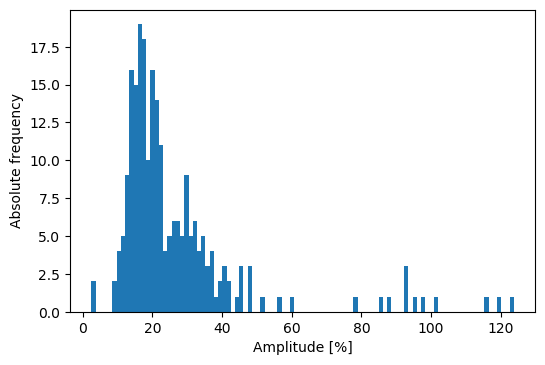

In [25]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(height, bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [26]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.25

In [27]:
components = (components.T / np.max(components, axis = 1)).T

In [28]:
values = np.hstack([np.array([width]).T, np.array([height]).T])
values = normalize(values)

In [29]:
values = np.hstack([values,np.array(flow_by_tot).T])

In [30]:
sources_sinks_train, sources_sinks_test = train_test_split(sources_sinks, test_size=test_size, random_state = random_state)
vectors_train, vectors_test = train_test_split(gcamp, test_size=test_size, random_state = random_state)
values_train, values_test = train_test_split(values, test_size=test_size, random_state = random_state)

sources_sinks_train =  np.expand_dims(sources_sinks_train,-1)
sources_sinks_test =  np.expand_dims(sources_sinks_test,-1)
vectors_train = np.expand_dims(vectors_train,-1)
vectors_test = np.expand_dims(vectors_test, -1)

vectors_train = np.expand_dims(vectors_train,1)
vectors_test = np.expand_dims(vectors_test, -1)

Save additional features as variables.

In [31]:
additional_features = [iso, corr, width, height, ratio_vertical_horizontal, up_flow, left_flow, flow_per_auc]
additional_features = [train_test_split(f, test_size=test_size, random_state = random_state) for f in additional_features]
add_train = [f[0] for f in additional_features]
add_test = [f[1] for f in additional_features]
iso_train, corr_train, width_train, height_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, flow_per_auc_train = add_train
iso_test, corr_test, width_test, height_test, ratio_vertical_horizontal_test, up_flow_test, left_flow_test, flow_per_auc_test = add_test

In [32]:
print("There are " + str(len(iso_test)) + " test samples")

There are 59 test samples


In [33]:
print("The maximal amplitude of the percentage change in time is " 
              + str(np.max(height_train).round()))

The maximal amplitude of the percentage change in time is 124.0


# Variational Autoenconder

In [35]:
## network parameters
from predictive_modeling.models.vae_cnn_v2a import *
from keras import Model

batch_size = 100
n_values = 6

In [36]:
[image_input, value_input, vector_input], [z_mean, z_log_var, z] = encoder(n_values)
latent_inputs, [image_decoded, values_decoded, vector_decoded] = decoder(n_values)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


../../predictive_modeling/models/vae_cnn_v2a.py:102: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[64, 128, ..., activation="relu", strides=(4, 4))`
  image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[64, 128,1], activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2a.py:103: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2a.py:104: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))


In [37]:
encoder_model = Model(inputs = [image_input, value_input, vector_input], outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = [image_decoded, values_decoded, vector_decoded], name='decoder')

In [38]:
image_decoded, values_decoded, vector_decoded = decoder_model(encoder_model([image_input, value_input, vector_input])[2])

In [39]:
vae = Model(inputs = [image_input, value_input, vector_input], 
            outputs = [image_decoded, values_decoded, vector_decoded], name='vae_mlp')

In [40]:
print("The input shapes of the autoencoder are: ")
print(image_input.shape)
print(value_input.shape)
print(vector_input.shape)

The input shapes of the autoencoder are: 
(None, 64, 128, 1)
(None, 6)
(None, 1, 128, 1)


In [41]:
import keras
loss, loss_width_height, loss_signal_in_time, img_reconstruction_loss, loss_dirs = get_vae_loss(image_input, value_input, vector_input, image_decoded, values_decoded, vector_decoded, z_mean, z_log_var, impact_reconstruction_loss = 100)
vae.add_loss(loss)
vae.add_metric(loss_width_height, name='loss_width_height')
vae.add_metric(loss_dirs, name='loss_dirs')
vae.add_metric(loss_signal_in_time, name='loss_signal_in_time')
vae.add_metric(img_reconstruction_loss, name='img_reconstruction_loss')

vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [42]:
x_train_combined = [sources_sinks_train, values_train, vectors_train]

In [43]:
# train the autoencoder
history = vae.fit(x_train_combined, epochs= 1000, batch_size=batch_size, verbose=2)

Epoch 1/1000
 - 11s - loss: 722.8932 - loss_width_height: 0.0971 - loss_dirs: 0.0840 - loss_signal_in_time: 0.1310 - img_reconstruction_loss: 0.0920
Epoch 2/1000
 - 2s - loss: 4419.4339 - loss_width_height: 0.3943 - loss_dirs: 0.5829 - loss_signal_in_time: 0.8353 - img_reconstruction_loss: 3.3477
Epoch 3/1000
 - 2s - loss: 598.3655 - loss_width_height: 0.0815 - loss_dirs: 0.0588 - loss_signal_in_time: 0.1085 - img_reconstruction_loss: 0.0660
Epoch 4/1000
 - 1s - loss: 630.7125 - loss_width_height: 0.0834 - loss_dirs: 0.0710 - loss_signal_in_time: 0.1221 - img_reconstruction_loss: 0.0837
Epoch 5/1000
 - 1s - loss: 625.4865 - loss_width_height: 0.0801 - loss_dirs: 0.0714 - loss_signal_in_time: 0.1228 - img_reconstruction_loss: 0.0909
Epoch 6/1000
 - 1s - loss: 602.0899 - loss_width_height: 0.0751 - loss_dirs: 0.0683 - loss_signal_in_time: 0.1212 - img_reconstruction_loss: 0.0935
Epoch 7/1000
 - 1s - loss: 572.5433 - loss_width_height: 0.0705 - loss_dirs: 0.0635 - loss_signal_in_time: 0.1

 - 1s - loss: 198.5712 - loss_width_height: 0.0162 - loss_dirs: 0.0268 - loss_signal_in_time: 0.0497 - img_reconstruction_loss: 0.0378
Epoch 57/1000
 - 1s - loss: 200.0221 - loss_width_height: 0.0171 - loss_dirs: 0.0267 - loss_signal_in_time: 0.0499 - img_reconstruction_loss: 0.0378
Epoch 58/1000
 - 1s - loss: 196.9300 - loss_width_height: 0.0158 - loss_dirs: 0.0264 - loss_signal_in_time: 0.0496 - img_reconstruction_loss: 0.0377
Epoch 59/1000
 - 1s - loss: 193.6628 - loss_width_height: 0.0160 - loss_dirs: 0.0261 - loss_signal_in_time: 0.0488 - img_reconstruction_loss: 0.0380
Epoch 60/1000
 - 1s - loss: 192.4303 - loss_width_height: 0.0139 - loss_dirs: 0.0268 - loss_signal_in_time: 0.0490 - img_reconstruction_loss: 0.0377
Epoch 61/1000
 - 1s - loss: 191.6735 - loss_width_height: 0.0145 - loss_dirs: 0.0262 - loss_signal_in_time: 0.0490 - img_reconstruction_loss: 0.0385
Epoch 62/1000
 - 1s - loss: 188.3677 - loss_width_height: 0.0147 - loss_dirs: 0.0262 - loss_signal_in_time: 0.0478 - img

Epoch 111/1000
 - 2s - loss: 107.2414 - loss_width_height: 0.0030 - loss_dirs: 0.0137 - loss_signal_in_time: 0.0340 - img_reconstruction_loss: 0.0267
Epoch 112/1000
 - 3s - loss: 105.9362 - loss_width_height: 0.0030 - loss_dirs: 0.0136 - loss_signal_in_time: 0.0340 - img_reconstruction_loss: 0.0270
Epoch 113/1000
 - 3s - loss: 105.5794 - loss_width_height: 0.0026 - loss_dirs: 0.0133 - loss_signal_in_time: 0.0339 - img_reconstruction_loss: 0.0269
Epoch 114/1000
 - 2s - loss: 104.6613 - loss_width_height: 0.0029 - loss_dirs: 0.0136 - loss_signal_in_time: 0.0335 - img_reconstruction_loss: 0.0272
Epoch 115/1000
 - 5s - loss: 102.5155 - loss_width_height: 0.0023 - loss_dirs: 0.0134 - loss_signal_in_time: 0.0333 - img_reconstruction_loss: 0.0270
Epoch 116/1000
 - 7s - loss: 102.4642 - loss_width_height: 0.0024 - loss_dirs: 0.0133 - loss_signal_in_time: 0.0336 - img_reconstruction_loss: 0.0271
Epoch 117/1000
 - 8s - loss: 102.5120 - loss_width_height: 0.0024 - loss_dirs: 0.0134 - loss_signal_

Epoch 166/1000
 - 2s - loss: 76.2296 - loss_width_height: 0.0014 - loss_dirs: 0.0095 - loss_signal_in_time: 0.0244 - img_reconstruction_loss: 0.0269
Epoch 167/1000
 - 2s - loss: 75.1029 - loss_width_height: 0.0012 - loss_dirs: 0.0097 - loss_signal_in_time: 0.0242 - img_reconstruction_loss: 0.0270
Epoch 168/1000
 - 2s - loss: 75.0382 - loss_width_height: 0.0013 - loss_dirs: 0.0099 - loss_signal_in_time: 0.0240 - img_reconstruction_loss: 0.0273
Epoch 169/1000
 - 2s - loss: 74.4613 - loss_width_height: 0.0012 - loss_dirs: 0.0095 - loss_signal_in_time: 0.0235 - img_reconstruction_loss: 0.0271
Epoch 170/1000
 - 2s - loss: 74.3365 - loss_width_height: 0.0013 - loss_dirs: 0.0096 - loss_signal_in_time: 0.0232 - img_reconstruction_loss: 0.0267
Epoch 171/1000
 - 2s - loss: 73.7708 - loss_width_height: 0.0013 - loss_dirs: 0.0094 - loss_signal_in_time: 0.0236 - img_reconstruction_loss: 0.0272
Epoch 172/1000
 - 2s - loss: 73.6312 - loss_width_height: 0.0012 - loss_dirs: 0.0093 - loss_signal_in_time

Epoch 221/1000
 - 1s - loss: 64.6028 - loss_width_height: 0.0011 - loss_dirs: 0.0082 - loss_signal_in_time: 0.0203 - img_reconstruction_loss: 0.0258
Epoch 222/1000
 - 1s - loss: 64.0878 - loss_width_height: 0.0012 - loss_dirs: 0.0076 - loss_signal_in_time: 0.0198 - img_reconstruction_loss: 0.0254
Epoch 223/1000
 - 1s - loss: 63.4564 - loss_width_height: 0.0012 - loss_dirs: 0.0080 - loss_signal_in_time: 0.0193 - img_reconstruction_loss: 0.0258
Epoch 224/1000
 - 1s - loss: 63.9481 - loss_width_height: 0.0011 - loss_dirs: 0.0079 - loss_signal_in_time: 0.0195 - img_reconstruction_loss: 0.0259
Epoch 225/1000
 - 3s - loss: 63.9211 - loss_width_height: 0.0011 - loss_dirs: 0.0079 - loss_signal_in_time: 0.0202 - img_reconstruction_loss: 0.0259
Epoch 226/1000
 - 4s - loss: 63.5056 - loss_width_height: 0.0012 - loss_dirs: 0.0079 - loss_signal_in_time: 0.0194 - img_reconstruction_loss: 0.0254
Epoch 227/1000
 - 2s - loss: 63.1899 - loss_width_height: 0.0011 - loss_dirs: 0.0077 - loss_signal_in_time

Epoch 276/1000
 - 1s - loss: 57.2724 - loss_width_height: 0.0010 - loss_dirs: 0.0067 - loss_signal_in_time: 0.0174 - img_reconstruction_loss: 0.0242
Epoch 277/1000
 - 1s - loss: 57.1607 - loss_width_height: 9.8134e-04 - loss_dirs: 0.0067 - loss_signal_in_time: 0.0175 - img_reconstruction_loss: 0.0243
Epoch 278/1000
 - 1s - loss: 56.4524 - loss_width_height: 8.9973e-04 - loss_dirs: 0.0068 - loss_signal_in_time: 0.0174 - img_reconstruction_loss: 0.0243
Epoch 279/1000
 - 1s - loss: 56.5510 - loss_width_height: 8.1807e-04 - loss_dirs: 0.0067 - loss_signal_in_time: 0.0177 - img_reconstruction_loss: 0.0239
Epoch 280/1000
 - 1s - loss: 56.6306 - loss_width_height: 8.2289e-04 - loss_dirs: 0.0070 - loss_signal_in_time: 0.0170 - img_reconstruction_loss: 0.0241
Epoch 281/1000
 - 2s - loss: 56.2078 - loss_width_height: 8.4916e-04 - loss_dirs: 0.0068 - loss_signal_in_time: 0.0175 - img_reconstruction_loss: 0.0241
Epoch 282/1000
 - 1s - loss: 56.2406 - loss_width_height: 9.0997e-04 - loss_dirs: 0.00

Epoch 330/1000
 - 1s - loss: 52.8872 - loss_width_height: 8.1456e-04 - loss_dirs: 0.0063 - loss_signal_in_time: 0.0158 - img_reconstruction_loss: 0.0234
Epoch 331/1000
 - 1s - loss: 53.5401 - loss_width_height: 8.4478e-04 - loss_dirs: 0.0067 - loss_signal_in_time: 0.0161 - img_reconstruction_loss: 0.0231
Epoch 332/1000
 - 1s - loss: 52.7435 - loss_width_height: 8.3753e-04 - loss_dirs: 0.0066 - loss_signal_in_time: 0.0154 - img_reconstruction_loss: 0.0232
Epoch 333/1000
 - 1s - loss: 52.0468 - loss_width_height: 7.8485e-04 - loss_dirs: 0.0067 - loss_signal_in_time: 0.0153 - img_reconstruction_loss: 0.0231
Epoch 334/1000
 - 7s - loss: 51.9648 - loss_width_height: 8.1351e-04 - loss_dirs: 0.0063 - loss_signal_in_time: 0.0153 - img_reconstruction_loss: 0.0229
Epoch 335/1000
 - 17s - loss: 52.3708 - loss_width_height: 8.8970e-04 - loss_dirs: 0.0063 - loss_signal_in_time: 0.0157 - img_reconstruction_loss: 0.0232
Epoch 336/1000
 - 3s - loss: 51.8777 - loss_width_height: 8.8786e-04 - loss_dirs:

Epoch 384/1000
 - 1s - loss: 48.1665 - loss_width_height: 6.8130e-04 - loss_dirs: 0.0059 - loss_signal_in_time: 0.0142 - img_reconstruction_loss: 0.0218
Epoch 385/1000
 - 1s - loss: 47.8642 - loss_width_height: 7.2023e-04 - loss_dirs: 0.0057 - loss_signal_in_time: 0.0141 - img_reconstruction_loss: 0.0221
Epoch 386/1000
 - 1s - loss: 47.5280 - loss_width_height: 7.1220e-04 - loss_dirs: 0.0053 - loss_signal_in_time: 0.0139 - img_reconstruction_loss: 0.0225
Epoch 387/1000
 - 1s - loss: 47.5711 - loss_width_height: 6.7434e-04 - loss_dirs: 0.0057 - loss_signal_in_time: 0.0139 - img_reconstruction_loss: 0.0223
Epoch 388/1000
 - 1s - loss: 47.4972 - loss_width_height: 7.0110e-04 - loss_dirs: 0.0054 - loss_signal_in_time: 0.0139 - img_reconstruction_loss: 0.0219
Epoch 389/1000
 - 1s - loss: 47.9122 - loss_width_height: 7.3133e-04 - loss_dirs: 0.0057 - loss_signal_in_time: 0.0143 - img_reconstruction_loss: 0.0223
Epoch 390/1000
 - 1s - loss: 47.3625 - loss_width_height: 7.4031e-04 - loss_dirs: 

Epoch 438/1000
 - 2s - loss: 45.2728 - loss_width_height: 7.8863e-04 - loss_dirs: 0.0051 - loss_signal_in_time: 0.0130 - img_reconstruction_loss: 0.0217
Epoch 439/1000
 - 1s - loss: 44.9661 - loss_width_height: 7.5123e-04 - loss_dirs: 0.0054 - loss_signal_in_time: 0.0129 - img_reconstruction_loss: 0.0215
Epoch 440/1000
 - 2s - loss: 44.8267 - loss_width_height: 7.1305e-04 - loss_dirs: 0.0050 - loss_signal_in_time: 0.0130 - img_reconstruction_loss: 0.0215
Epoch 441/1000
 - 2s - loss: 45.0959 - loss_width_height: 6.8873e-04 - loss_dirs: 0.0051 - loss_signal_in_time: 0.0130 - img_reconstruction_loss: 0.0215
Epoch 442/1000
 - 2s - loss: 45.3344 - loss_width_height: 8.0182e-04 - loss_dirs: 0.0054 - loss_signal_in_time: 0.0127 - img_reconstruction_loss: 0.0215
Epoch 443/1000
 - 1s - loss: 45.1037 - loss_width_height: 7.8370e-04 - loss_dirs: 0.0053 - loss_signal_in_time: 0.0131 - img_reconstruction_loss: 0.0217
Epoch 444/1000
 - 1s - loss: 45.5258 - loss_width_height: 8.3360e-04 - loss_dirs: 

Epoch 492/1000
 - 1s - loss: 43.2588 - loss_width_height: 6.7940e-04 - loss_dirs: 0.0048 - loss_signal_in_time: 0.0124 - img_reconstruction_loss: 0.0210
Epoch 493/1000
 - 1s - loss: 42.3539 - loss_width_height: 7.3303e-04 - loss_dirs: 0.0045 - loss_signal_in_time: 0.0124 - img_reconstruction_loss: 0.0209
Epoch 494/1000
 - 1s - loss: 43.0087 - loss_width_height: 7.3983e-04 - loss_dirs: 0.0045 - loss_signal_in_time: 0.0125 - img_reconstruction_loss: 0.0211
Epoch 495/1000
 - 1s - loss: 42.4201 - loss_width_height: 7.1862e-04 - loss_dirs: 0.0044 - loss_signal_in_time: 0.0123 - img_reconstruction_loss: 0.0207
Epoch 496/1000
 - 1s - loss: 42.1753 - loss_width_height: 6.6366e-04 - loss_dirs: 0.0045 - loss_signal_in_time: 0.0119 - img_reconstruction_loss: 0.0210
Epoch 497/1000
 - 1s - loss: 42.1044 - loss_width_height: 7.1105e-04 - loss_dirs: 0.0046 - loss_signal_in_time: 0.0119 - img_reconstruction_loss: 0.0208
Epoch 498/1000
 - 1s - loss: 42.3674 - loss_width_height: 7.0548e-04 - loss_dirs: 

Epoch 546/1000
 - 1s - loss: 40.9532 - loss_width_height: 7.5538e-04 - loss_dirs: 0.0041 - loss_signal_in_time: 0.0117 - img_reconstruction_loss: 0.0204
Epoch 547/1000
 - 1s - loss: 40.9776 - loss_width_height: 7.6254e-04 - loss_dirs: 0.0043 - loss_signal_in_time: 0.0117 - img_reconstruction_loss: 0.0202
Epoch 548/1000
 - 1s - loss: 40.8035 - loss_width_height: 7.2332e-04 - loss_dirs: 0.0044 - loss_signal_in_time: 0.0117 - img_reconstruction_loss: 0.0203
Epoch 549/1000
 - 1s - loss: 40.4517 - loss_width_height: 7.3757e-04 - loss_dirs: 0.0040 - loss_signal_in_time: 0.0118 - img_reconstruction_loss: 0.0203
Epoch 550/1000
 - 1s - loss: 40.5484 - loss_width_height: 6.5866e-04 - loss_dirs: 0.0043 - loss_signal_in_time: 0.0116 - img_reconstruction_loss: 0.0202
Epoch 551/1000
 - 2s - loss: 41.2009 - loss_width_height: 6.7896e-04 - loss_dirs: 0.0043 - loss_signal_in_time: 0.0120 - img_reconstruction_loss: 0.0204
Epoch 552/1000
 - 12s - loss: 41.4107 - loss_width_height: 7.1027e-04 - loss_dirs:

Epoch 600/1000
 - 1s - loss: 39.4390 - loss_width_height: 6.9727e-04 - loss_dirs: 0.0041 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0196
Epoch 601/1000
 - 1s - loss: 39.0331 - loss_width_height: 7.0360e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0109 - img_reconstruction_loss: 0.0198
Epoch 602/1000
 - 1s - loss: 39.3135 - loss_width_height: 6.4470e-04 - loss_dirs: 0.0040 - loss_signal_in_time: 0.0113 - img_reconstruction_loss: 0.0196
Epoch 603/1000
 - 1s - loss: 39.2397 - loss_width_height: 6.1838e-04 - loss_dirs: 0.0041 - loss_signal_in_time: 0.0109 - img_reconstruction_loss: 0.0197
Epoch 604/1000
 - 1s - loss: 38.7421 - loss_width_height: 6.2407e-04 - loss_dirs: 0.0039 - loss_signal_in_time: 0.0108 - img_reconstruction_loss: 0.0197
Epoch 605/1000
 - 1s - loss: 38.9764 - loss_width_height: 6.5428e-04 - loss_dirs: 0.0040 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0196
Epoch 606/1000
 - 1s - loss: 38.8375 - loss_width_height: 6.3056e-04 - loss_dirs: 

Epoch 654/1000
 - 1s - loss: 40.6100 - loss_width_height: 7.3469e-04 - loss_dirs: 0.0046 - loss_signal_in_time: 0.0113 - img_reconstruction_loss: 0.0196
Epoch 655/1000
 - 1s - loss: 40.9870 - loss_width_height: 6.9953e-04 - loss_dirs: 0.0044 - loss_signal_in_time: 0.0115 - img_reconstruction_loss: 0.0200
Epoch 656/1000
 - 1s - loss: 40.6007 - loss_width_height: 6.5840e-04 - loss_dirs: 0.0042 - loss_signal_in_time: 0.0116 - img_reconstruction_loss: 0.0195
Epoch 657/1000
 - 1s - loss: 40.3540 - loss_width_height: 6.6676e-04 - loss_dirs: 0.0046 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0195
Epoch 658/1000
 - 1s - loss: 39.4664 - loss_width_height: 7.0591e-04 - loss_dirs: 0.0043 - loss_signal_in_time: 0.0110 - img_reconstruction_loss: 0.0191
Epoch 659/1000
 - 1s - loss: 39.4441 - loss_width_height: 6.2722e-04 - loss_dirs: 0.0045 - loss_signal_in_time: 0.0109 - img_reconstruction_loss: 0.0195
Epoch 660/1000
 - 1s - loss: 38.6558 - loss_width_height: 5.8398e-04 - loss_dirs: 

Epoch 708/1000
 - 1s - loss: 37.1249 - loss_width_height: 6.3939e-04 - loss_dirs: 0.0037 - loss_signal_in_time: 0.0103 - img_reconstruction_loss: 0.0187
Epoch 709/1000
 - 1s - loss: 37.4555 - loss_width_height: 6.2980e-04 - loss_dirs: 0.0040 - loss_signal_in_time: 0.0104 - img_reconstruction_loss: 0.0190
Epoch 710/1000
 - 1s - loss: 37.4913 - loss_width_height: 6.2617e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0104 - img_reconstruction_loss: 0.0191
Epoch 711/1000
 - 1s - loss: 37.1074 - loss_width_height: 5.9740e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0103 - img_reconstruction_loss: 0.0191
Epoch 712/1000
 - 1s - loss: 37.1583 - loss_width_height: 6.0874e-04 - loss_dirs: 0.0037 - loss_signal_in_time: 0.0103 - img_reconstruction_loss: 0.0191
Epoch 713/1000
 - 1s - loss: 37.3011 - loss_width_height: 6.3524e-04 - loss_dirs: 0.0039 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0189
Epoch 714/1000
 - 1s - loss: 37.8412 - loss_width_height: 6.2896e-04 - loss_dirs: 

Epoch 762/1000
 - 1s - loss: 36.1800 - loss_width_height: 5.8186e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0185
Epoch 763/1000
 - 1s - loss: 36.1384 - loss_width_height: 6.0120e-04 - loss_dirs: 0.0037 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0182
Epoch 764/1000
 - 1s - loss: 36.1731 - loss_width_height: 5.7276e-04 - loss_dirs: 0.0036 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0184
Epoch 765/1000
 - 1s - loss: 36.4442 - loss_width_height: 6.1418e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0185
Epoch 766/1000
 - 1s - loss: 36.1439 - loss_width_height: 5.6177e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0185
Epoch 767/1000
 - 1s - loss: 36.3321 - loss_width_height: 5.0956e-04 - loss_dirs: 0.0040 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0182
Epoch 768/1000
 - 1s - loss: 36.2132 - loss_width_height: 5.6801e-04 - loss_dirs: 

Epoch 816/1000
 - 1s - loss: 35.8355 - loss_width_height: 5.8495e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0182
Epoch 817/1000
 - 1s - loss: 35.8228 - loss_width_height: 5.9737e-04 - loss_dirs: 0.0039 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0178
Epoch 818/1000
 - 1s - loss: 36.4857 - loss_width_height: 6.4962e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0179
Epoch 819/1000
 - 1s - loss: 35.8521 - loss_width_height: 5.5710e-04 - loss_dirs: 0.0037 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0180
Epoch 820/1000
 - 1s - loss: 35.6706 - loss_width_height: 6.2015e-04 - loss_dirs: 0.0036 - loss_signal_in_time: 0.0096 - img_reconstruction_loss: 0.0181
Epoch 821/1000
 - 1s - loss: 35.5226 - loss_width_height: 5.1177e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0178
Epoch 822/1000
 - 1s - loss: 35.6784 - loss_width_height: 5.4525e-04 - loss_dirs: 

Epoch 870/1000
 - 1s - loss: 35.3224 - loss_width_height: 6.2626e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0177
Epoch 871/1000
 - 1s - loss: 34.7215 - loss_width_height: 5.7072e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0093 - img_reconstruction_loss: 0.0175
Epoch 872/1000
 - 1s - loss: 35.0040 - loss_width_height: 5.4619e-04 - loss_dirs: 0.0036 - loss_signal_in_time: 0.0096 - img_reconstruction_loss: 0.0177
Epoch 873/1000
 - 1s - loss: 34.8331 - loss_width_height: 5.5296e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0176
Epoch 874/1000
 - 1s - loss: 34.6661 - loss_width_height: 5.2459e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0182
Epoch 875/1000
 - 1s - loss: 34.7612 - loss_width_height: 5.3142e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0174
Epoch 876/1000
 - 1s - loss: 34.8042 - loss_width_height: 5.7461e-04 - loss_dirs: 

Epoch 924/1000
 - 1s - loss: 34.9267 - loss_width_height: 5.6847e-04 - loss_dirs: 0.0039 - loss_signal_in_time: 0.0093 - img_reconstruction_loss: 0.0174
Epoch 925/1000
 - 1s - loss: 34.6118 - loss_width_height: 5.9260e-04 - loss_dirs: 0.0036 - loss_signal_in_time: 0.0093 - img_reconstruction_loss: 0.0173
Epoch 926/1000
 - 1s - loss: 34.8063 - loss_width_height: 5.8639e-04 - loss_dirs: 0.0037 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0174
Epoch 927/1000
 - 1s - loss: 35.1498 - loss_width_height: 5.9350e-04 - loss_dirs: 0.0037 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0176
Epoch 928/1000
 - 1s - loss: 35.0128 - loss_width_height: 5.8681e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0175
Epoch 929/1000
 - 1s - loss: 34.7186 - loss_width_height: 6.0834e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0173
Epoch 930/1000
 - 1s - loss: 35.2418 - loss_width_height: 6.9085e-04 - loss_dirs: 

Epoch 978/1000
 - 1s - loss: 34.1502 - loss_width_height: 5.4378e-04 - loss_dirs: 0.0036 - loss_signal_in_time: 0.0090 - img_reconstruction_loss: 0.0170
Epoch 979/1000
 - 1s - loss: 33.8213 - loss_width_height: 5.0465e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0089 - img_reconstruction_loss: 0.0172
Epoch 980/1000
 - 1s - loss: 34.2227 - loss_width_height: 5.1969e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0171
Epoch 981/1000
 - 1s - loss: 35.2670 - loss_width_height: 5.0299e-04 - loss_dirs: 0.0038 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0165
Epoch 982/1000
 - 1s - loss: 33.7998 - loss_width_height: 5.1567e-04 - loss_dirs: 0.0036 - loss_signal_in_time: 0.0089 - img_reconstruction_loss: 0.0169
Epoch 983/1000
 - 1s - loss: 34.3457 - loss_width_height: 5.1090e-04 - loss_dirs: 0.0035 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0170
Epoch 984/1000
 - 1s - loss: 34.8107 - loss_width_height: 4.7655e-04 - loss_dirs: 

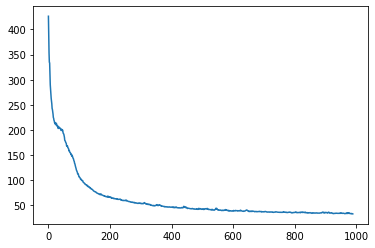

In [45]:
plt.plot(vae.history.history["loss"][10:])

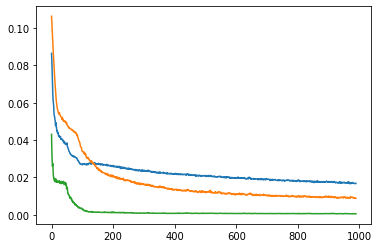

In [46]:
plt.plot(vae.history.history["img_reconstruction_loss"][10:])
plt.plot(vae.history.history["loss_signal_in_time"][10:])
plt.plot(vae.history.history["loss_width_height"][10:])
#plt.plot(vae.history.history["val_loss_direction"][10:])

# Visualize predictions

In [47]:
res = vae.predict(x_train_combined)

In [48]:
val_predictions = res[1]

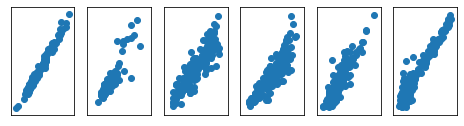

In [49]:
fig, ax = plt.subplots(1,6, figsize = (8,2))
for x, lab in enumerate(["width", "height", "left", "right", "up", "down"]):
    ax[x].scatter(val_predictions[:,0+x], values_train[:,0+x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])

In [51]:
from scipy.ndimage import median_filter

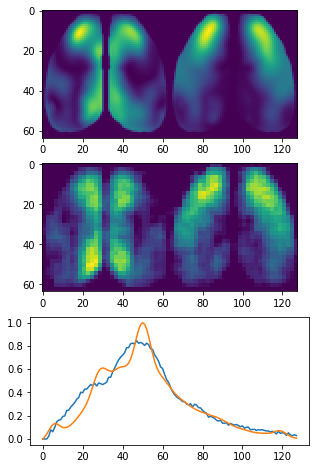

In [78]:
i = 120
fig, ax = plt.subplots(3, figsize= (5,8))
ax[0].imshow(sources_sinks_train[i][:,:,0])
ax[1].imshow(res[0][i][:,:,0])

ax[2].plot(res[2][i][0,:128,0])
ax[2].plot(vectors_train[i][0,:128,0])

In [53]:
res = vae.predict(x_train_combined)

In [54]:
from plots import manifold,manifold_of_images, manifold_of_vector_components

In [55]:
#Predictions for z[0] and z[1] neurons i.e. x and y for the train and test datasets 
x_pred_train, y_pred_train = encoder_model.predict(x_train_combined)[2].T

In [56]:
%%capture
x_min = np.mean(x_pred_train)-2*np.std(x_pred_train)
y_min = np.mean(y_pred_train)-2*np.std(y_pred_train)
x_max = np.mean(x_pred_train)+2*np.std(x_pred_train)
y_max = np.mean(y_pred_train)+2*np.std(y_pred_train)
x_range = [x_min, x_max]
y_range = [y_min, y_max]

man_mean_signal = manifold(decoder_model, x_range, y_range, n = 15, dpi = 300, scale="sqrt", multi_output = True)

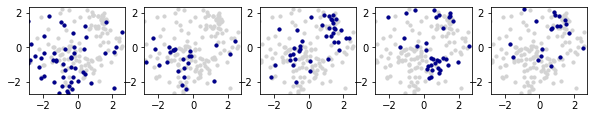

In [146]:
z_train = encoder_model.predict(x_train_combined)[2].T

fig, ax = plt.subplots(1,5, figsize= (10,5))
isos = [1.8, 2.0, 2.2, 2.4, 2.6]

def add_feature_plot(ax, iso, size = 10):
    ax.scatter(*z_train, c= "lightgray", s = size)
    ax.scatter(*(z_train.T[iso_train == iso]).T, c = "darkblue", s=size)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect(1)

for iso, a in zip(isos,ax):
    add_feature_plot(a, iso)

In [87]:
%%capture
manifold_vector_components = manifold_of_vector_components(x_range = x_range, y_range = y_range, decoder_model = decoder_model, debug = False)

In [88]:
sources_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sources")
sinks_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sinks")

In [89]:
#plt.plot(decoder_model.predict([[[2,2]]])[2][0,0,:,0])

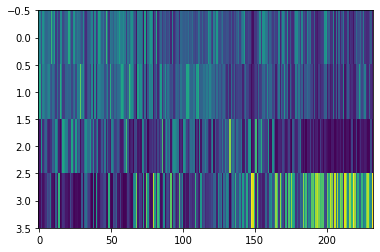

In [90]:
plt.imshow(flow_by_tot, aspect = "auto")

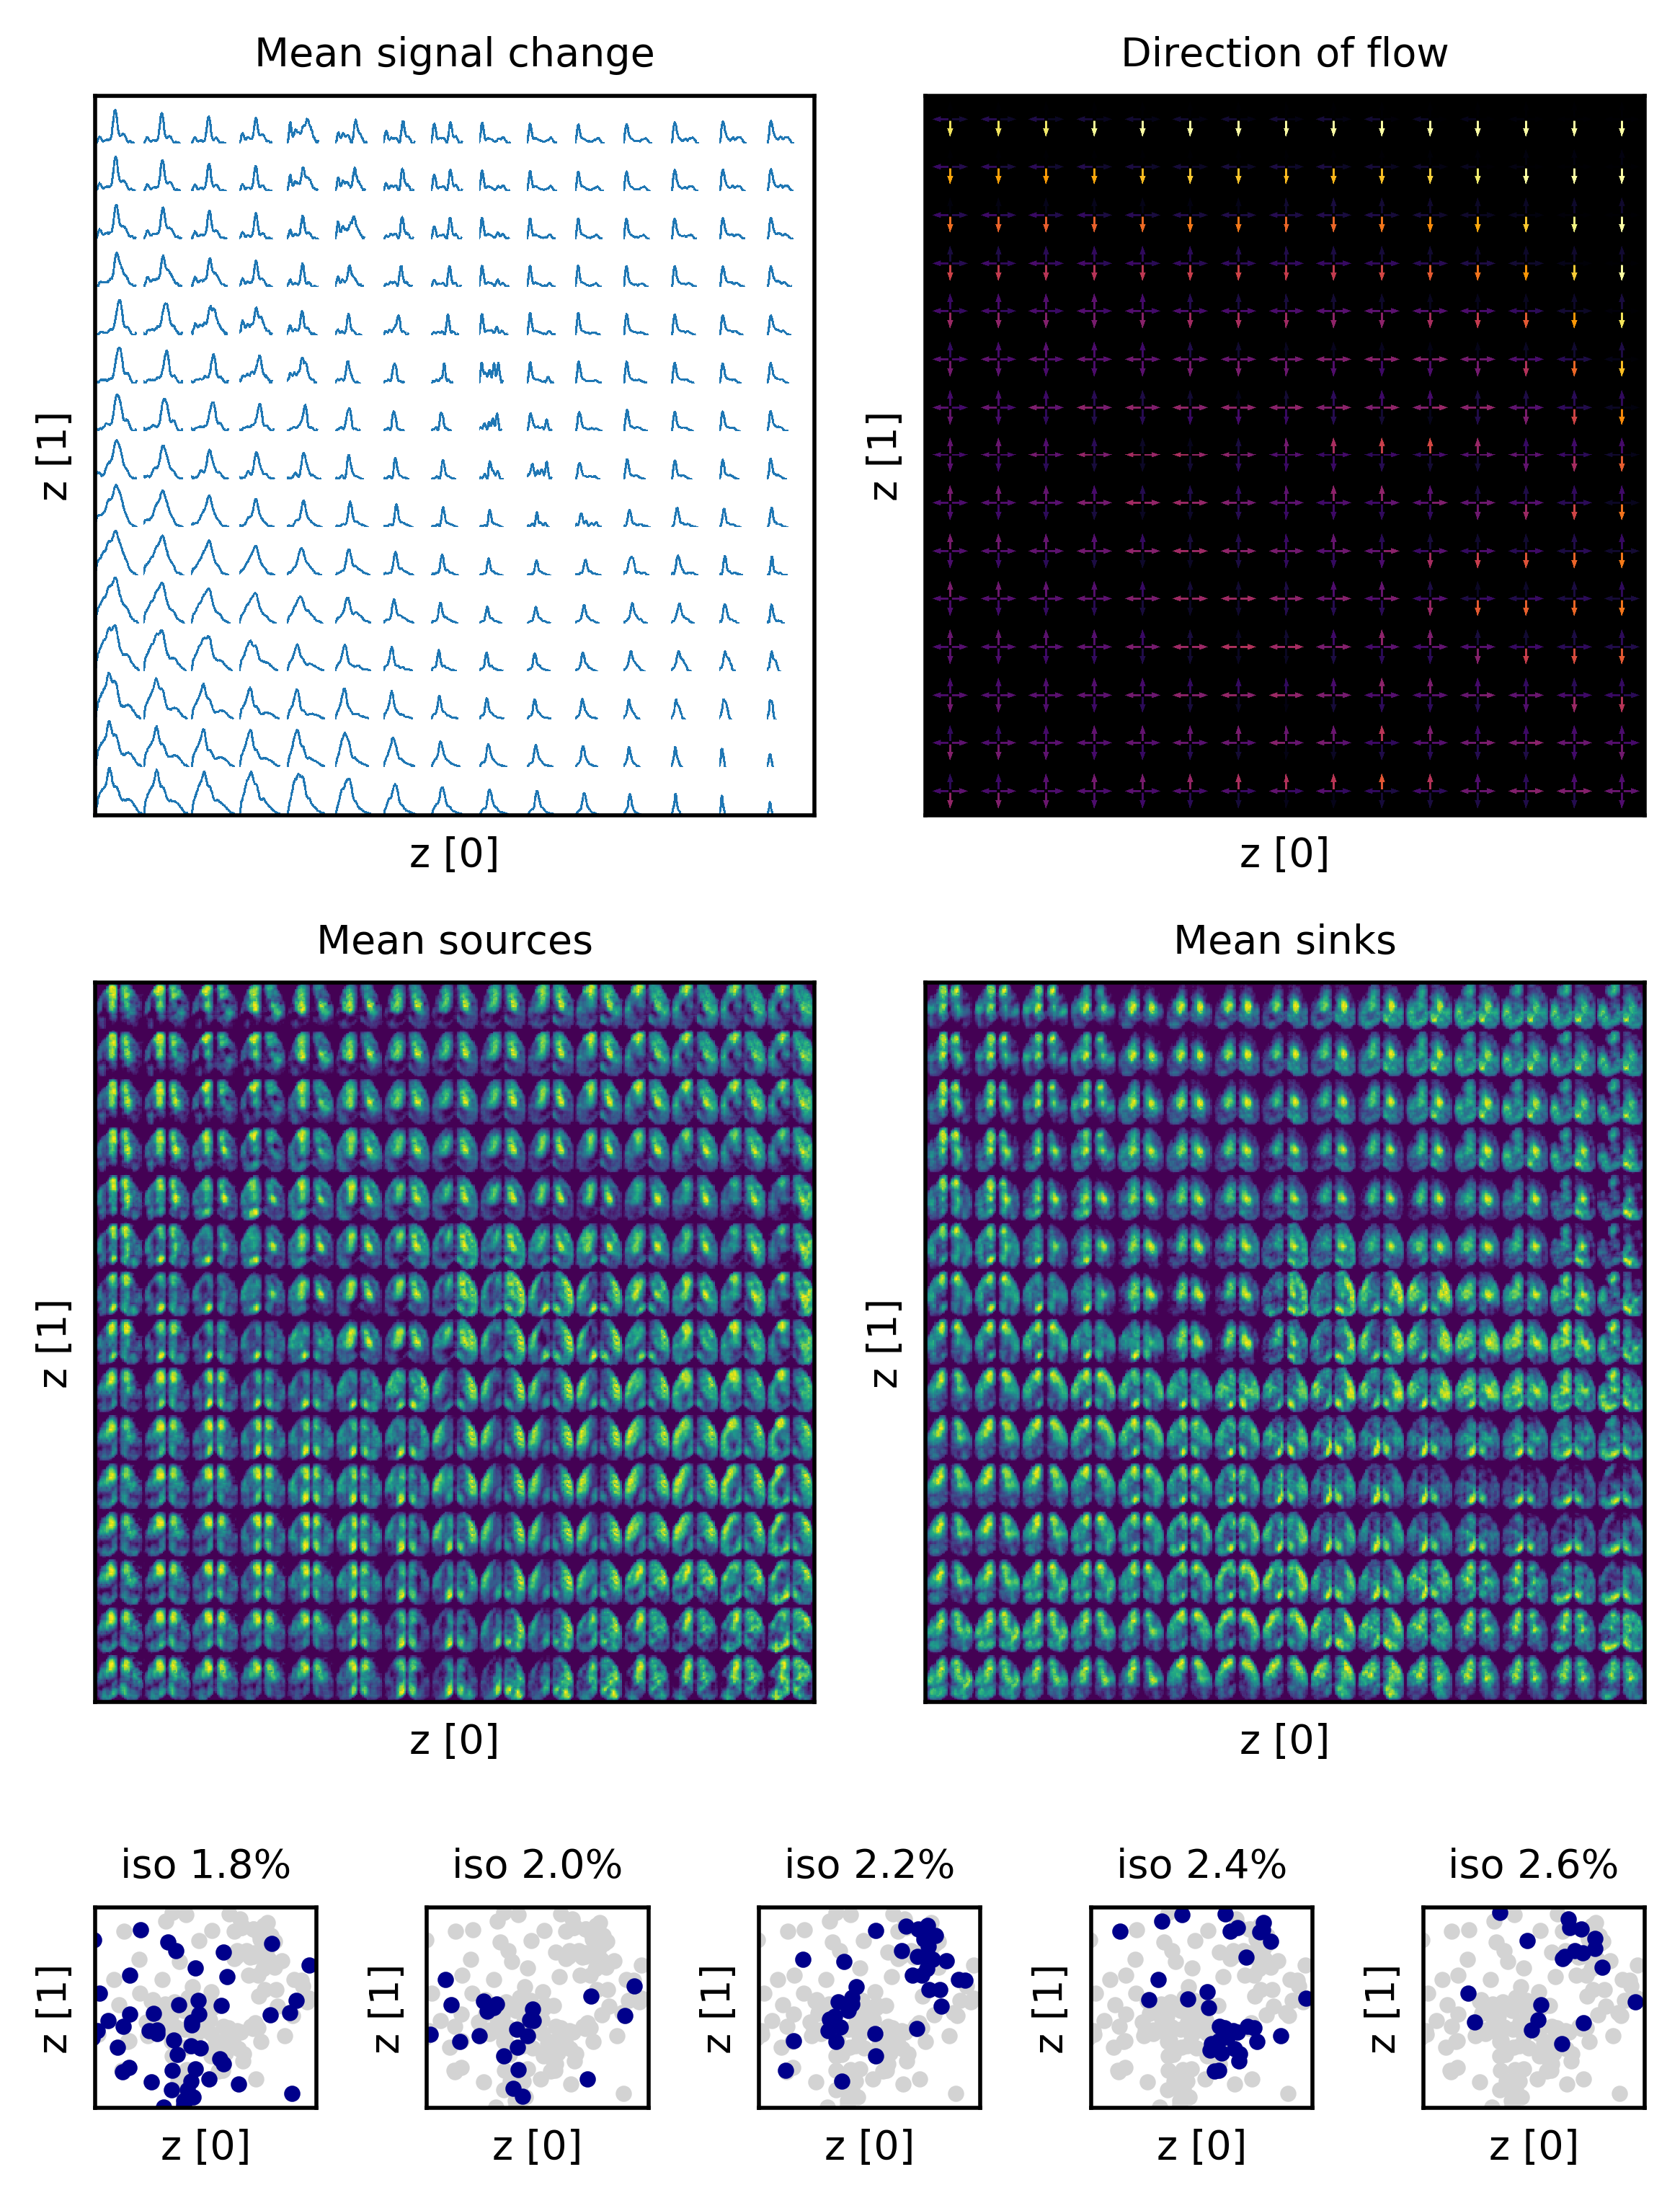

In [336]:
fig = plt.figure(constrained_layout = False, figsize = (10, 8), dpi = 500)

gs1 = fig.add_gridspec(nrows = 5, ncols = 10, left=0.05, right=0.48, wspace = 2, hspace = .1)

axs = []
axs.append(fig.add_subplot(gs1[0:2, 0:5]))
axs.append(fig.add_subplot(gs1[0:2, 5:10]))
axs.append(fig.add_subplot(gs1[2:4, 0:5]))
axs.append(fig.add_subplot(gs1[2:4, 5:10]))

axs_manifolds = axs.copy()

axs_scatter = []
for i in np.arange(5)*2:
    a = fig.add_subplot(gs1[-1, i:i+2])
    axs.append(a)
    axs_scatter.append(a)
    
for iso, a in zip(isos,axs_scatter):
    add_feature_plot(a, iso, size = 5)

axs[0].imshow(man_mean_signal)
axs[1].imshow(manifold_vector_components)
axs[2].imshow(sources_manifold)
axs[3].imshow(sinks_manifold)


for a, t in zip(axs_manifolds, ["Mean signal change", "Direction of flow", "Mean sources", "Mean sinks"]):
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(t, fontsize = 8)
    a.set_xlabel("z [0]", fontsize = 8)
    a.set_ylabel("z [1]", fontsize = 8)
    
for i, a in enumerate(axs_scatter):
    a.set_xticks([])
    a.set_yticks([])
    a.set_title("iso " + str(isos[i]) + "%", fontsize = 8)
    a.set_xlabel("z [0]", fontsize = 8)
    a.set_ylabel("z [1]", fontsize = 8)

# Investigate time series

In [164]:
x_combined = [np.expand_dims(sources_sinks,-1), values, np.expand_dims(np.expand_dims(gcamp, -1),1)]

In [187]:
recordings = np.array(encoder_model.predict(x_combined)[2]).T

In [205]:
np.where(iso_levels == 2.6)

(array([111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 214, 215,
        216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232]),)

In [267]:
def animate_latent_space(recordings, iso_levels, time_window = 5, xlim=(-5, 5), ylim = (-5, 5)):
    steps = len(recordings[0]) - time_window
    fig = plt.figure()
    ax = plt.axes(xlim = xlim, ylim = ylim)
    line, = ax.plot([],[], lw = 2)
    def init():
        line.set_data([], [])
        return line,
    def animate(i):
        i += time_window
        x, y = recordings[0][i-time_window:i], recordings[1][i-time_window:i]
        line.set_data(x,y)
        return line,

    anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=steps, interval = 75, blit=True)
    return anim

In [298]:
def plot_time_series_in_latent_space(recordings, iso_levels, ax = None):
    if type(ax) == type(None):
        fig, ax = plt.subplots(1)
        ax.set_xlabel("z [0]")
        ax.set_ylabel("z [1]")
    ax.plot(recordings[0][iso_levels==1.8],recordings[1][iso_levels==1.8], label = "1.8%")
    ax.plot(recordings[0][iso_levels==2.0],recordings[1][iso_levels==2.0], label = "2.0%")
    ax.plot(recordings[0][iso_levels==2.2],recordings[1][iso_levels==2.2], label = "2.2%")
    ax.plot(recordings[0][iso_levels==2.4],recordings[1][iso_levels==2.4], label = "2.4%")
    ax.plot(recordings[0][iso_levels==2.6],recordings[1][iso_levels==2.6], label = "2.6%")
    ax.legend()

In [324]:
from scipy.ndimage import variance

def get_variance(recordings, iso_levels, isos, start = 0, stop = -1):
    recordings = recordings[:,start:stop]
    iso_levels = iso_levels[start:stop]
    variances = []
    for iso in list(set(isos)):
        rec_iso = recordings[:,iso_levels==iso]
        variances.append(variance(rec_iso))
    return np.array(variances)

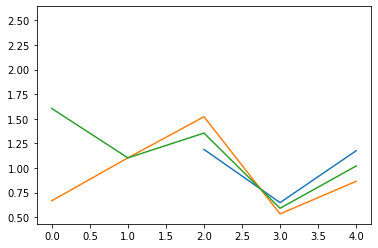

In [331]:
var_a = get_variance(recordings, iso_levels, isos, start = 121, stop = -1)
var_b = get_variance(recordings, iso_levels, isos, start = 0, stop = 121)
plt.plot(var_a)
plt.plot(var_b)
plt.plot(np.nanmean([var_a, var_b], axis = 0))

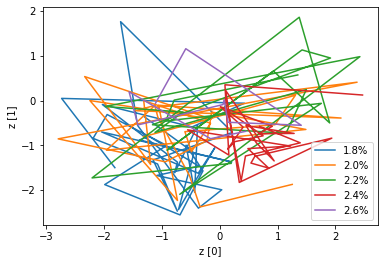

In [299]:
plot_time_series_in_latent_space(recordings[:,:121], iso_levels[:121])


In [271]:
%%capture
anim = animate_latent_space(recordings[:,:121], iso_levels[:121], xlim = (-3,3), ylim = (-3,3))
anim1 = animate_latent_space(recordings[:,121:], iso_levels[121:], xlim = (-3,3), ylim = (-3,3))

In [272]:
HTML(anim1.to_jshtml())

In [269]:
HTML(anim.to_jshtml())

# Visualization

In [ ]:
vae.save("full_vae")

In [ ]:
vae = keras.models.load_model("full_vae", custom_objects={'tf': tf}, compile = False)